In [1]:
!pip install langchain_community langchain langgraph langchain-openai openai

In [2]:
import getpass
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key: ··········


In [3]:
from pydantic import BaseModel, Field
from typing import List, Optional

class TextAnalysisSchema(BaseModel):
    sentence_original: str = Field(..., description="The sentence from the original text being analyzed for plagiarism.")
    sentence_comparison: str = Field(..., description="The sentence from the comparison text being compared for plagiarism.")
    likelihood_of_plagiarism: float = Field(..., description="The likelihood that this sentence is plagiarized, between 0 and 1.")
    flagged_for_review: bool = Field(..., description="Whether this sentence should be flagged for review due to suspicious similarities.")

class PlagiarismSuspicionSuggestionSchema(BaseModel):
    sentence_original: str = Field(..., description="The sentence from the original text flagged as potentially plagiarized.")
    sentence_comparison: str = Field(..., description="The sentence from the comparison text that is similar to the flagged sentence.")
    suggestion: str = Field(..., description="A suggestion on why this sentence may be plagiarized, including detected patterns or similarities.")
    likelihood_of_plagiarism: float = Field(..., description="The likelihood that this part of the text is plagiarized, based on detected patterns.")

class PlagiarismCorrectionSchema(BaseModel):
    original_sentence: str = Field(..., description="The original sentence flagged as plagiarized.")
    corrected_sentence: str = Field(..., description="The revised sentence to avoid suspicion of plagiarism.")
    reason_for_correction: str = Field(..., description="Explanation for why this sentence was corrected, based on detected patterns.")

class FinalPlagiarismCheckSchema(BaseModel):
    final_text: str = Field(..., description="The final version of the text after corrections have been applied.")
    final_check: str = Field(..., description="The final determination of whether the text is likely plagiarized. Answer must be 'yes' or 'no' in lowercase.")
    review_notes: str = Field(..., description="Additional notes or comments on the final evaluation of the text.")

In [4]:
class IsPlagiarismResponseSchema(BaseModel):
    is_plagiarized: str = Field(..., description="Whether the text is likely plagiarized. Answer must be 'yes' or 'no' in lowercase.")

class TextAnalysisResponseSchema(BaseModel):
    text_analysis: List[TextAnalysisSchema] = Field(
        ..., description="The detailed analysis of the text, indicating the likelihood of plagiarism between two texts for each sentence."
    )

class PlagiarismSuspicionSuggestionResponseSchema(BaseModel):
    plagiarism_suspicion_suggestions: List[PlagiarismSuspicionSuggestionSchema] = Field(
        ..., description="List of sentences flagged as potentially plagiarized, with suggestions on why they may be considered plagiarized."
    )

class PlagiarismCorrectionResponseSchema(BaseModel):
    plagiarism_corrections: List[PlagiarismCorrectionSchema] = Field(
        ..., description="List of corrections applied to sentences or segments that were flagged as plagiarized to reduce suspicion."
    )

class FinalPlagiarismCheckResponseSchema(BaseModel):
    final_plagiarism_check: FinalPlagiarismCheckSchema = Field(
        ..., description="The final evaluation determining if the text passes the plagiarism check between the two texts, with a 'yes' or 'no' answer and review notes."
    )

In [5]:
from typing import Dict, TypedDict, Optional

class GraphState(TypedDict):
    original_text: str
    comparison_text: str
    lang: str

    is_plagiarized: str

    text_analysis: List[TextAnalysisSchema]

    plagiarism_suspicion_suggestions: List[PlagiarismSuspicionSuggestionSchema]

    plagiarism_corrections: List[PlagiarismCorrectionSchema]

    final_plagiarism_check: FinalPlagiarismCheckSchema

In [6]:
from langgraph.graph import StateGraph
workflow = StateGraph(GraphState)

In [7]:
from langchain_openai import ChatOpenAI
from langchain.schema import (
       AIMessage,
       HumanMessage,
       SystemMessage
  )

llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.7)

In [8]:
from langchain_core.output_parsers import JsonOutputParser

def is_text_plagiarized(state):
    json_parser = JsonOutputParser(pydantic_object=IsPlagiarismResponseSchema)

    lang = state['lang']
    original_text = state['original_text']
    comparison_text = state['comparison_text']

    messages = [
        SystemMessage(content=f"You are a plagiarism detection expert for {lang} texts."),
        HumanMessage(content=f"""Please compare the following two texts and determine if the original text is likely plagiarized from the comparison text.
        Focus on similarities in phrasing, structure, and content. Based on your analysis, respond only with 'yes' if the original text is plagiarized, or 'no' if it is not. Answer in lowercase.

        Original Text:
        {original_text}

        Comparison Text:
        {comparison_text}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"Plagiarism Check: {parsed_result}")

    return {
        "is_plagiarized": parsed_result["is_plagiarized"]
    }

In [9]:
def decide_to_continue(state: GraphState):

    is_plagiarized = state["is_plagiarized"]

    if is_plagiarized == "yes":
        print("---DECISION: CONTINUE---")
        return "continue"
    else:
        print("---DECISION: FINISH---")
        return "end"

In [10]:
from langchain_core.output_parsers import JsonOutputParser

def analyze_text_for_plagiarism(state):
    json_parser = JsonOutputParser(pydantic_object=TextAnalysisResponseSchema)

    lang = state['lang']
    original_text = state['original_text']
    comparison_text = state['comparison_text']

    messages = [
        SystemMessage(content=f"You are a plagiarism detection expert for {lang} texts."),
        HumanMessage(content=f"""Please analyze the following texts and determine the likelihood that each sentence in the original text is plagiarized from the comparison text.
        For each sentence, indicate the likelihood as a probability between 0 and 1, and flag any sentence that should be reviewed due to suspicious similarities.

        Original Text:
        {original_text}

        Comparison Text:
        {comparison_text}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"Text Analysis for Plagiarism Detection: {parsed_result}")

    return {
        "text_analysis": parsed_result["text_analysis"]
    }

In [11]:
def generate_plagiarism_suspicion_suggestions(state):
    json_parser = JsonOutputParser(pydantic_object=PlagiarismSuspicionSuggestionResponseSchema)

    lang = state['lang']
    text_analysis = state['text_analysis']

    formatted_analysis = "\n".join(
        [f"Original Sentence: {analysis['sentence_original']}, Comparison Sentence: {analysis['sentence_comparison']}, Likelihood of Plagiarism: {analysis['likelihood_of_plagiarism']}"
        for analysis in text_analysis if analysis['flagged_for_review']]
    )

    messages = [
        SystemMessage(content=f"You are a plagiarism detection expert for {lang} texts."),
        HumanMessage(content=f"""Please review the following text analysis and provide suggestions for any sentences flagged as potentially plagiarized.
        For each flagged sentence, explain why it might be plagiarized and suggest any corrections if necessary.

        Text Analysis:
        {formatted_analysis}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"Plagiarism Suspicion Suggestions: {parsed_result}")

    return {
        "plagiarism_suspicion_suggestions": parsed_result["plagiarism_suspicion_suggestions"]
    }

In [12]:
def apply_plagiarism_corrections(state):
    json_parser = JsonOutputParser(pydantic_object=PlagiarismCorrectionResponseSchema)

    lang = state['lang']
    plagiarism_suspicion_suggestions = state['plagiarism_suspicion_suggestions']

    formatted_suggestions = "\n".join(
        [f"Original Sentence: {suggestion['sentence_original']}, Suggestion: {suggestion['suggestion']}"
        for suggestion in plagiarism_suspicion_suggestions]
    )

    messages = [
        SystemMessage(content=f"You are a plagiarism correction expert for {lang} texts."),
        HumanMessage(content=f"""Based on the following plagiarism suspicion suggestions, please apply corrections to reduce suspicion that the text is plagiarized.
        For each flagged sentence, provide a corrected version and explain why the correction reduces the suspicion of plagiarism.

        Plagiarism Suspicion Suggestions:
        {formatted_suggestions}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"Plagiarism Corrections: {parsed_result}")

    return {
        "plagiarism_corrections": parsed_result["plagiarism_corrections"]
    }

In [13]:
def final_plagiarism_check(state):
    json_parser = JsonOutputParser(pydantic_object=FinalPlagiarismCheckResponseSchema)

    lang = state['lang']
    plagiarism_corrections = state['plagiarism_corrections']

    formatted_corrections = "\n".join(
        [f"Original Sentence: {correction['original_sentence']}, Corrected Sentence: {correction['corrected_sentence']}"
        for correction in plagiarism_corrections]
    )

    messages = [
        SystemMessage(content=f"You are a plagiarism checker expert for {lang} texts."),
        HumanMessage(content=f"""Please review the following corrections made to the text that was previously flagged for plagiarism.
        Based on these corrections, determine if the text now passes the plagiarism check. Respond with 'yes' if the text is no longer suspected to be plagiarized, or 'no' if it still presents characteristics of plagiarism.
        Additionally, provide any review notes if necessary.

        Plagiarism Corrections:
        {formatted_corrections}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"Final Plagiarism Check: {parsed_result}")

    return {
        "final_plagiarism_check": parsed_result["final_plagiarism_check"]
    }

In [14]:
def decide_to_finish(state: GraphState):

    final_check = state["final_plagiarism_check"]["final_check"]

    if final_check == "yes":
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "no"

In [15]:
from langgraph.graph import END

workflow.add_node("is_text_plagiarized", is_text_plagiarized)
workflow.add_node("analyze_text_for_plagiarism", analyze_text_for_plagiarism)

workflow.add_node("generate_plagiarism_suspicion_suggestions", generate_plagiarism_suspicion_suggestions)
workflow.add_node("apply_plagiarism_corrections", apply_plagiarism_corrections)
workflow.add_node("final_plagiarism_check_node", final_plagiarism_check)

workflow.set_entry_point("is_text_plagiarized")
workflow.add_conditional_edges(
    "is_text_plagiarized",
    decide_to_continue,
    {
        "continue": "analyze_text_for_plagiarism",
        "end": END,
    },
)
workflow.add_edge('analyze_text_for_plagiarism', "generate_plagiarism_suspicion_suggestions")
workflow.add_edge('generate_plagiarism_suspicion_suggestions', "apply_plagiarism_corrections")
workflow.add_edge('apply_plagiarism_corrections', "final_plagiarism_check_node")

workflow.add_conditional_edges(
    "final_plagiarism_check_node",
    decide_to_finish,
    {
        "end": END,
        "no": "apply_plagiarism_corrections",
    },
)

In [16]:
app = workflow.compile()

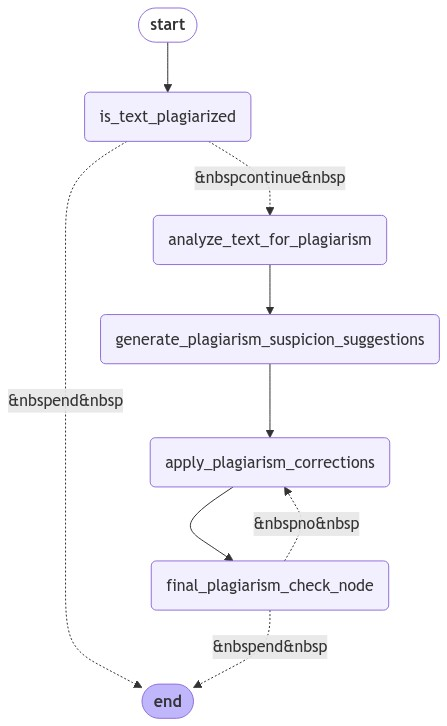

In [17]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [18]:
inputs = {
    "original_text": """
    La tecnología ha avanzado a pasos agigantados en las últimas décadas, transformando la manera en que las personas viven y trabajan.
    Hoy en día, es posible comunicarse con alguien al otro lado del mundo en cuestión de segundos, gracias a las redes globales de internet.
    Además, los dispositivos móviles permiten acceder a una cantidad infinita de información desde cualquier lugar, haciendo que el mundo esté más conectado que nunca.
    """,
    "comparison_text": """
    En las últimas décadas, la tecnología ha evolucionado enormemente, cambiando la forma en que vivimos y trabajamos.
    Actualmente, es posible conectarse con cualquier persona en el mundo en cuestión de segundos, gracias a las redes de internet.
    Los teléfonos móviles, por su parte, nos brindan acceso a una cantidad ilimitada de información desde cualquier sitio, logrando que estemos más interconectados que nunca.
    """,
    "lang": "es"
    ""}

result = app.invoke(inputs)

Plagiarism Check: {'is_plagiarized': 'yes'}
---DECISION: CONTINUE---
Text Analysis for Plagiarism Detection: {'text_analysis': [{'sentence_original': 'La tecnología ha avanzado a pasos agigantados en las últimas décadas, transformando la manera en que las personas viven y trabajan.', 'sentence_comparison': 'En las últimas décadas, la tecnología ha evolucionado enormemente, cambiando la forma en que vivimos y trabajamos.', 'likelihood_of_plagiarism': 0.8, 'flagged_for_review': True}, {'sentence_original': 'Hoy en día, es posible comunicarse con alguien al otro lado del mundo en cuestión de segundos, gracias a las redes globales de internet.', 'sentence_comparison': 'Actualmente, es posible conectarse con cualquier persona en el mundo en cuestión de segundos, gracias a las redes de internet.', 'likelihood_of_plagiarism': 0.85, 'flagged_for_review': True}, {'sentence_original': 'Además, los dispositivos móviles permiten acceder a una cantidad infinita de información desde cualquier lugar,

In [19]:
result

{'original_text': '\n    La tecnología ha avanzado a pasos agigantados en las últimas décadas, transformando la manera en que las personas viven y trabajan. \n    Hoy en día, es posible comunicarse con alguien al otro lado del mundo en cuestión de segundos, gracias a las redes globales de internet. \n    Además, los dispositivos móviles permiten acceder a una cantidad infinita de información desde cualquier lugar, haciendo que el mundo esté más conectado que nunca.\n    ',
 'comparison_text': '\n    En las últimas décadas, la tecnología ha evolucionado enormemente, cambiando la forma en que vivimos y trabajamos. \n    Actualmente, es posible conectarse con cualquier persona en el mundo en cuestión de segundos, gracias a las redes de internet. \n    Los teléfonos móviles, por su parte, nos brindan acceso a una cantidad ilimitada de información desde cualquier sitio, logrando que estemos más interconectados que nunca.\n    ',
 'lang': 'es',
 'is_plagiarized': 'yes',
 'text_analysis': [{'

In [20]:
inputs = {
    "original_text": """
    El cambio climático está afectando gravemente a las comunidades más vulnerables del mundo. Las sequías prolongadas y las inundaciones están desplazando a millones de personas,
    obligándolas a abandonar sus hogares en busca de lugares más seguros. Además, el acceso a recursos esenciales como agua potable y alimentos se ha vuelto cada vez más
    limitado en regiones propensas a fenómenos extremos, lo que genera tensiones sociales y migraciones masivas.
    """,
    "comparison_text": """
    El aumento de las temperaturas ha tenido consecuencias devastadoras para muchas especies animales. Los osos polares, por ejemplo, están viendo reducido su hábitat natural
    a medida que el hielo marino del Ártico se derrite a un ritmo alarmante. Del mismo modo, muchas aves migratorias están cambiando sus rutas debido a alteraciones en los
    patrones climáticos, lo que afecta sus ciclos reproductivos y la disponibilidad de alimento en las zonas de destino.
    """,
    "lang": "es"
    ""}

result2 = app.invoke(inputs)

Plagiarism Check: {'is_plagiarized': 'no'}
---DECISION: FINISH---


In [21]:
result2

{'original_text': '\n    El cambio climático está afectando gravemente a las comunidades más vulnerables del mundo. Las sequías prolongadas y las inundaciones están desplazando a millones de personas, \n    obligándolas a abandonar sus hogares en busca de lugares más seguros. Además, el acceso a recursos esenciales como agua potable y alimentos se ha vuelto cada vez más \n    limitado en regiones propensas a fenómenos extremos, lo que genera tensiones sociales y migraciones masivas.\n    ',
 'comparison_text': '\n    El aumento de las temperaturas ha tenido consecuencias devastadoras para muchas especies animales. Los osos polares, por ejemplo, están viendo reducido su hábitat natural \n    a medida que el hielo marino del Ártico se derrite a un ritmo alarmante. Del mismo modo, muchas aves migratorias están cambiando sus rutas debido a alteraciones en los \n    patrones climáticos, lo que afecta sus ciclos reproductivos y la disponibilidad de alimento en las zonas de destino.\n    ',
 